# Description
This notebook develops a classifier for variable stars detected with ZTF. The data is downloded from following url http://variables.cn:88/ztf/ 
The data is contains 23 features processed from the ZTF light curves and corresponding variable type label. The data contains 781,602 labled periodic variables. 
The notebook demonstrates the use of a simple random forest classifer for the Labeled data set

## Import modules

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Import Labeled Data set

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('Labeled_data.txt', header=None, delim_whitespace=True, skiprows=37) # extract data
labeled_data.columns = header_pd.iloc[:,3]

In [3]:
label = labeled_data.Type.unique()

## Variable Type Distribution in the data

<AxesSubplot:xlabel='Type', ylabel='Count'>

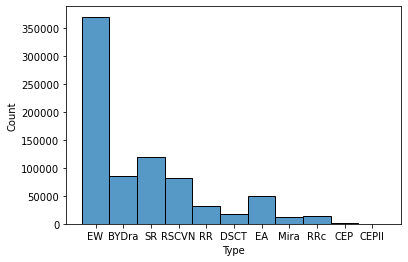

In [4]:
import seaborn as sns
sns.histplot(data=labeled_data, x=labeled_data.Type)

# Train a Classifier

## Split into training and test data

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# for X data
X = labeled_data

# Encode labels to form y labels
le = preprocessing.LabelEncoder()
le.fit(label)
y = le.transform(labeled_data.Type)

# Split dataset into training set and test set
X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
X_train = X_tr.drop(['ID','SourceID', 'RAdeg','DEdeg', 'Type'],axis='columns')
X_test = X_ts.drop(['ID','SourceID', 'RAdeg','DEdeg', 'Type'],axis='columns')

## Distribution of variable star types in the training data

<AxesSubplot:xlabel='Type', ylabel='Count'>

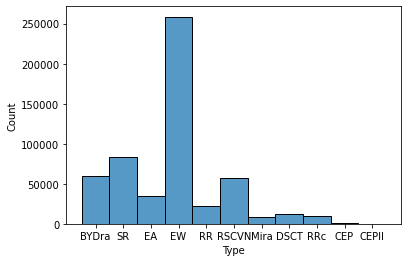

In [6]:
sns.histplot(data=labeled_data, x=X_tr.Type)

## Train a simple Random Forest estimator

In [7]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# Predict test data output
y_pred=clf.predict(X_test)

# Estimate model accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9360076082923563


## Prediction Error distribution accross variable type class

In [ ]:
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Form a dataframe of test vs predicted labels
pd_prediction = pd.DataFrame()
pd_prediction['Test'] = y_test_labels
pd_prediction['Pred'] = y_pred_labels
pd_prediction['Accuracy'] = y_test_labels == y_pred_labels
pd_prediction.head()

sns.histplot(data=pd_prediction, x=pd_prediction.Test, hue = pd_prediction.Accuracy)

# sns.histplot(data=pred_err, x=pred_err.Test)


# Visualize Feature importance

In [ ]:
# Feature Description
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
header_pd.head(30)

In [ ]:
# feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

In [ ]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Plot location of test data

In [ ]:
import astropy.coordinates as coord
import astropy.units as u

ra = coord.Angle(X_ts.RAdeg, unit=u.degree)

ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(X_ts.DEdeg, unit=u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)

# Hypertune the Random Forest Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
best_rf = rf_random.best_estimator_
# Predict test data output
y_pred=best_rf.predict(X_test)
# Estimate model accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))